# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [7]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [26]:
train['hour'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month
train['year'] = train.index.year

test['hour'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month
test['year'] = test.index.year

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [27]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

<ipython-input-27-4e42388e480f>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)
<ipython-input-27-4e42388e480f>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [28]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [29]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_test = test.drop(['No'], axis=1)
X_test = scaler_X.transform(X_test)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [30]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mape'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [32]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0075 - mae: 0.0622 - mape: 10935.1416 - val_loss: 0.0057 - val_mae: 0.0534 - val_mape: 106.8152 - learning_rate: 0.0010
Epoch 2/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0059 - mae: 0.0542 - mape: 2490.0598 - val_loss: 0.0056 - val_mae: 0.0565 - val_mape: 131.8071 - learning_rate: 0.0010
Epoch 3/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0056 - mae: 0.0527 - mape: 570.8692 - val_loss: 0.0052 - val_mae: 0.0518 - val_mape: 109.6191 - learning_rate: 0.0010
Epoch 4/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0057 - mae: 0.0531 - mape: 3095.7080 - val_loss: 0.0051 - val_mae: 0.0495 - val_mape: 94.3068 - learning_rate: 0.0010
Epoch 5/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0055 - mae: 0.0521 - mape: 1634.1205 - val_loss: 0.0051 - val_mae: 0.0520 - val_mape: 108.5975 - learning_rate: 0.0010
Epoch 6/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0056 - mae: 0.0524 - 

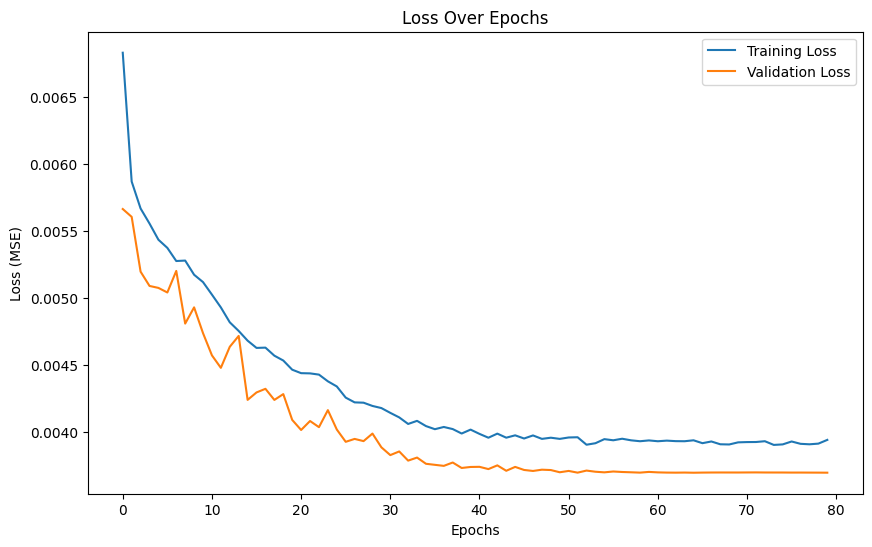

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [34]:
# Predict on the test data
predictions = model.predict(X_test)

# Inverse scale predictions back to the original scale
predictions = scaler_y.inverse_transform(predictions)

# Prepare submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Save the submission file in the current directory
submission.to_csv('submission.csv', index=False)
print("Submission file saved in the current directory.")

# Verify the file exists
import os
if os.path.exists('submission.csv'):
    print("File exists. Ready to download.")
else:
    print("File not found. Check the saving process.")

# Download the file
from google.colab import files
files.download('submission.csv')

411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Submission file saved in the current directory.
File exists. Ready to download.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
from google.colab import files

files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>